# HW8 | Saxpy + cupy bifuycation

Daniil Sherki

------
#### Task

This task is about studying how cupy library works. In summary, it has a numpy interface but keeps arrays on GPU. But for more reference you can visit the library's documentationLinks to an external site..

First, compare numpy and cupy in terms of the saxpy operation. Saxpy is 𝑧=𝛼𝑥+𝑦 , where 𝑧, 𝑥, 𝑦 are arrays of arbitrary size, and 𝛼 is a scalar.

Second, use cupy to implement the logistic map (from Hw1).

 

CRITERIA:

1. An explanation is given of what is the difference between cupy and numpy. How does cupy handle data transfers between CPU and GPU? (1 point)

2. Function saxpy that runs on GPU using cupy is provided. (1 point)

3.  Graph (OX - size of arrays, OY - computation time) is given. Plot computation time of numpy and cupy implementations of saxpy. (2 points)

4. Bifurcation map is performed using cupy arrays. (2 points)

5. Graph (OX - number of rs, OY - computation time) is given. Plot computation time of CPU, CPU parallel, and GPU implementations. (2 points)

---------

#### Explanation

As I am understand correctly, ```cupy``` is a library that provides a similar interface to ```numpy```, but provides for computations to be performed on the GPU instead of the CPU. The main difference between ```cupy``` and ```numpy``` is that ```cupy``` stores and operates on arrays directly on the GPU, while ```numpy``` operates on arrays stored in CPU memory. 

When using ```cupy```, data transfers between the CPU and GPU are handled by the library automatically. Initially, the data is transferred from the CPU to the GPU memory when creating a ```cupy``` array. Then, any computations performed on the ```cupy``` array are executed on the GPU. Finally, the results can be transferred back to the CPU if necessary.

In [2]:
from __future__ import annotations

import cupy as cp

def saxpy(alpha, x, y):
    return alpha * x + y

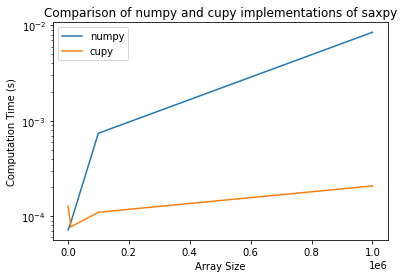

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

sizes = [10**3, 10**4, 10**5, 10**6]  # Array sizes to test

numpy_times = []
cupy_times = []

for size in sizes:
    x = np.random.randn(size)
    y = np.random.randn(size)
    alpha = np.random.rand()

    numpy_start_time = time.time()
    z_numpy = saxpy(alpha, x, y)
    numpy_end_time = time.time()
    numpy_times.append(numpy_end_time - numpy_start_time)

    x_gpu = cp.asarray(x)
    y_gpu = cp.asarray(y)
    alpha_gpu = cp.asarray(alpha)
    cupy_start_time = time.time()
    z_cupy = saxpy(alpha_gpu, x_gpu, y_gpu)
    cupy_end_time = time.time()
    cupy_times.append(cupy_end_time - cupy_start_time)

plt.plot(sizes, numpy_times, label='numpy')
plt.plot(sizes, cupy_times, label='cupy')
plt.yscale('log')
plt.xlabel('Array Size')
plt.ylabel('Computation Time (s)')
plt.title('Comparison of numpy and cupy implementations of saxpy')
plt.legend()
plt.show()

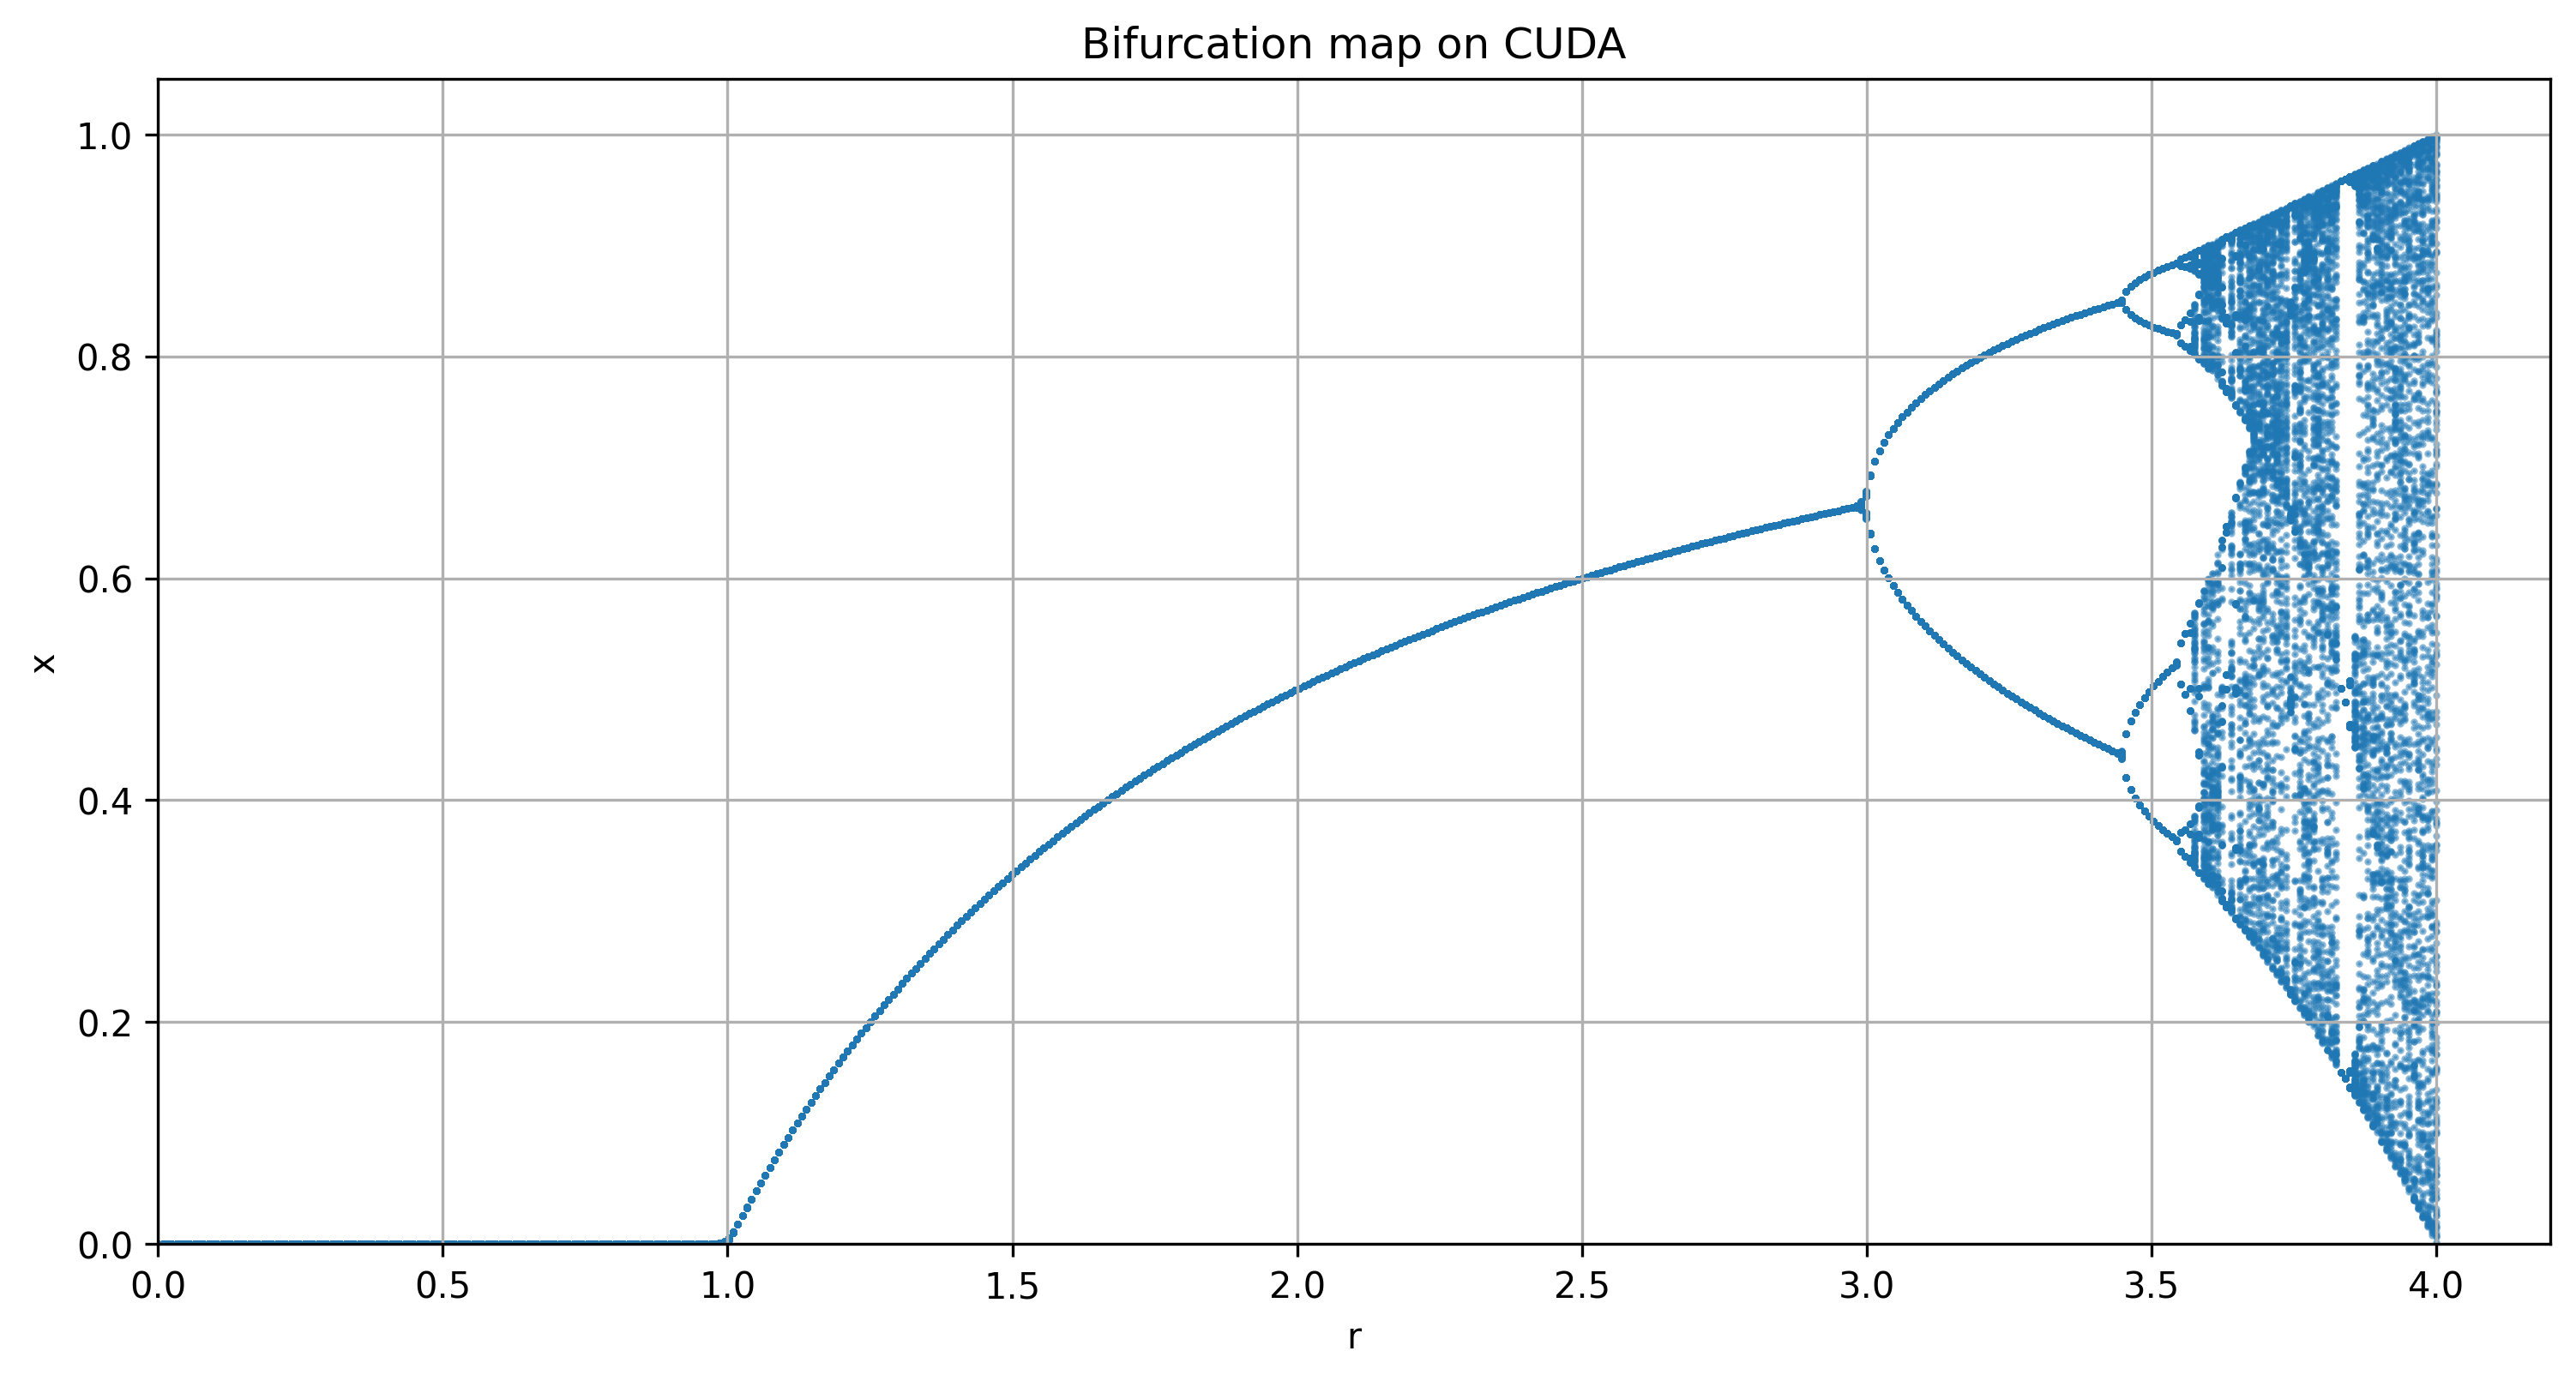

In [7]:
from multiprocessing import Pool

def logistic_map_cpu(r: float, n_iter: int, x0: float,) -> np.array:
    x = np.zeros(n_iter)
    x[0] = x0

    for i in range(1, n_iter):
        x[i] = r * x[i-1] * (1 - x[i-1])

    return x

def create_bifurcation_cpu(n: int, m: int, r_list: np.array, x0: float) -> None:
    log_maps = np.zeros((len(r_list), n+m))
    for i,r in enumerate(r_list):
        log_maps[i] = logistic_map_cpu(r = r, n_iter = n+m, x0 = x0)
    return log_maps


def create_bifurcation_parallel(n: int, m: int, r_list: np.array, x0: float) -> np.array:
    pool = Pool(processes=10)
    results = [pool.apply_async(logistic_map_cpu, (r, n+m, x0)) for r in r_list]
    log_maps = [result.get() for result in results]
    return np.array(log_maps)

def logistic_map_cuda(r: float, n_iter: int, x0: float,) -> np.array:
    x = cp.empty(n_iter)
    x[0] = x0

    for i in range(1, n_iter):
        x[i] = r * x[i-1] * (1 - x[i-1])

    return x

def create_bifurcation_cuda(n: int, m: int, r_list: np.array, x0: float) -> None:
    log_maps = cp.empty((len(r_list), n+m))
    for i,r in enumerate(r_list):
        log_maps[i] = logistic_map_cuda(r = r, n_iter = n+m, x0 = x0)
    return log_maps

def create_bifurcation_cuda_vis(n: int, m: int, r_list: np.array, x0: float) -> None:
    plt.figure(figsize=(12,6), dpi=300)

    for r in r_list:
        log_map = logistic_map_cuda(r = r, n_iter = n+m, x0 = x0)
        plt.scatter([r]*m, log_map[n:].get(), c='tab:blue', s=1, alpha=.5)
    plt.grid(True)
    plt.xlabel('r')
    plt.ylabel('x')
    plt.title('Bifurcation map on CUDA')
    plt.xlim(0)
    plt.ylim(0)
    plt.show()
    return log_map

_ = create_bifurcation_cuda_vis(n = 200, m = 200, r_list = np.linspace(0,4,500).tolist(), x0 = 0.4)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 15.29it/s]


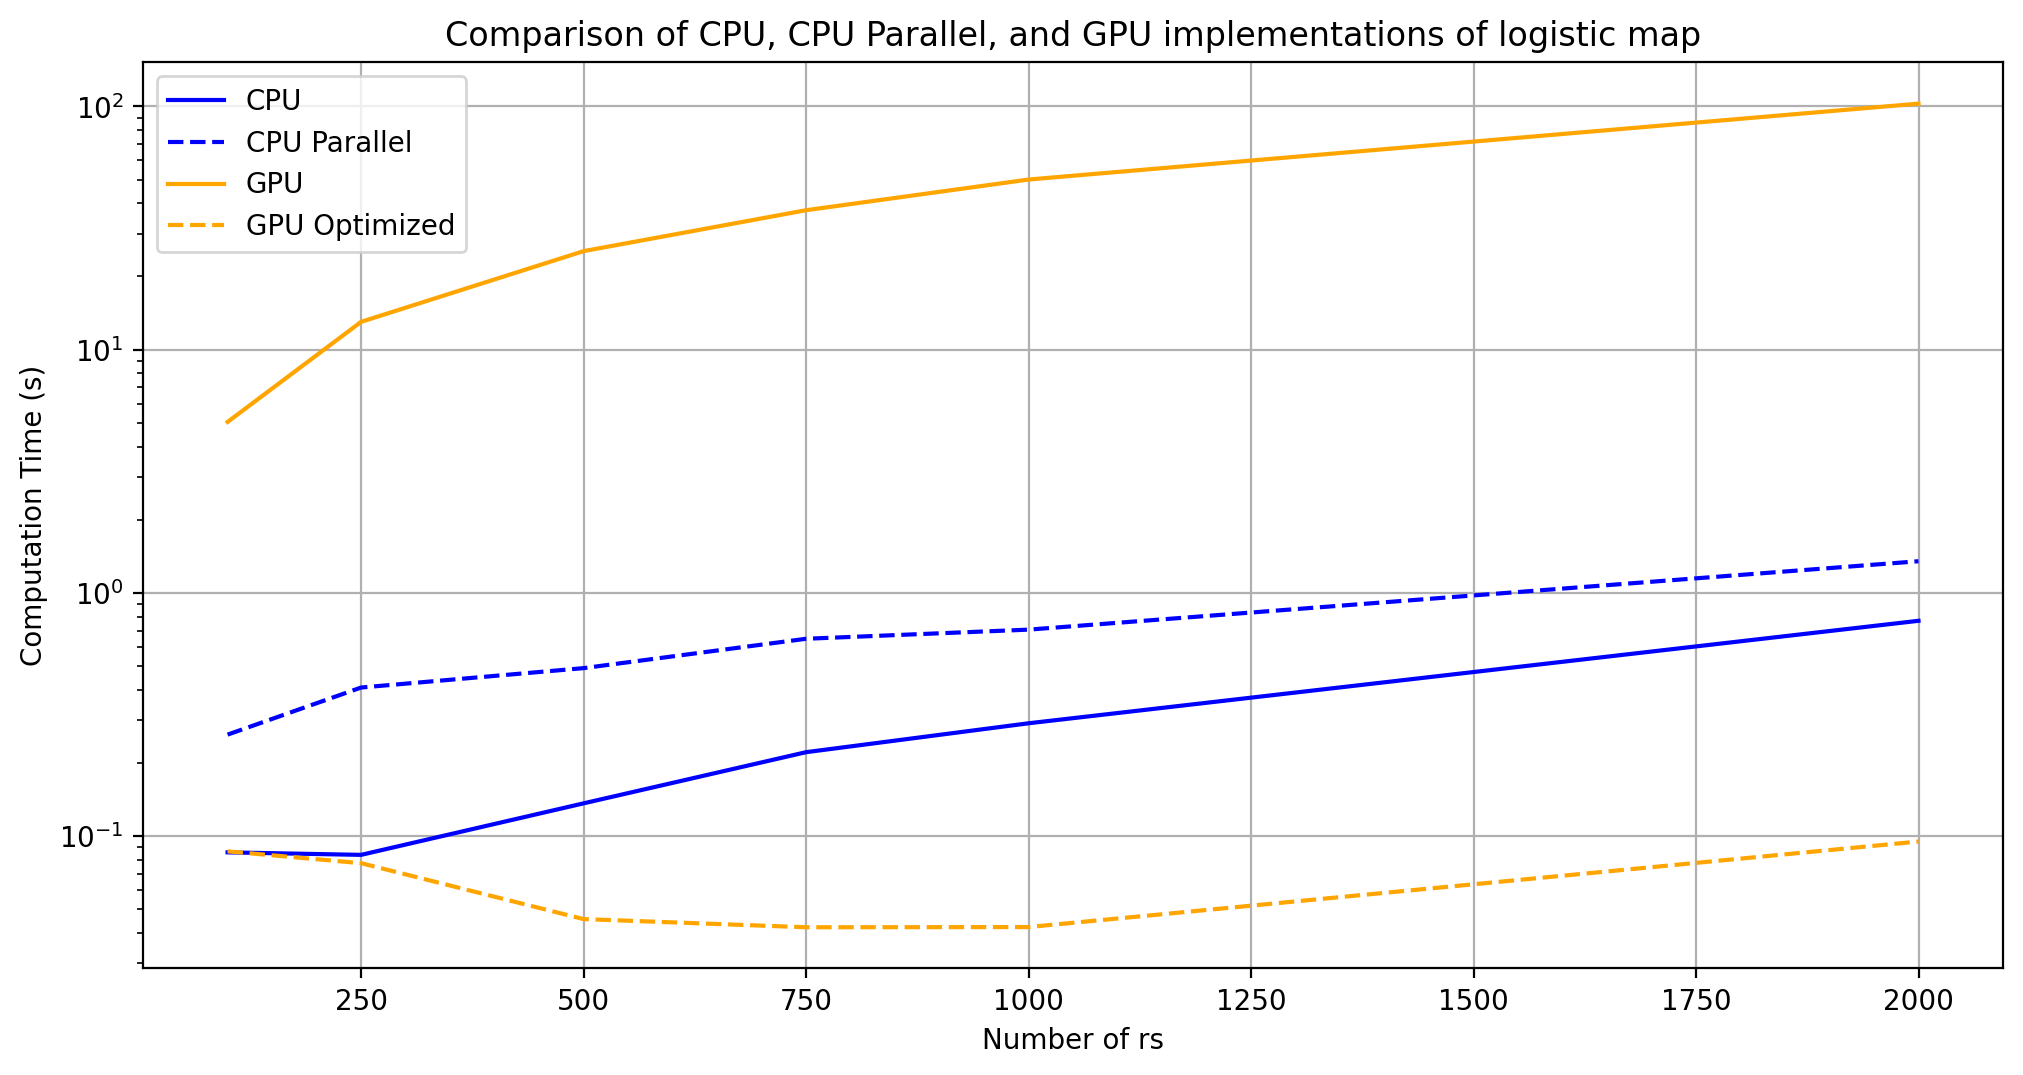

In [10]:
from tqdm import tqdm

def compute_cpu(rsizes):
    times = []
    for rs in tqdm(rsizes):
        start_time = time.time()
        _ = create_bifurcation_cpu(n = 200, m = 200, r_list = np.linspace(0,4,rs).tolist(), x0 = 0.4)
        end_time = time.time()
        times.append(end_time - start_time)
    
    return times

def compute_parallel(rsizes):
    times = []
    for rs in tqdm(rsizes):
        start_time = time.time()
        _ = create_bifurcation_parallel(n = 200, m = 200, r_list = np.linspace(0,4,rs).tolist(), x0 = 0.4)
        end_time = time.time()
        times.append(end_time - start_time)
    
    return times

def compute_cuda(rsizes):
    times = []
    for rs in tqdm(rsizes):
        start_time = time.time()
        _ = create_bifurcation_cuda(n = 200, m = 200, r_list = np.linspace(0,4,rs).tolist(), x0 = 0.4)
        end_time = time.time()
        times.append(end_time - start_time)
    
    return times

@cp.fuse()
def logistic_map(r, x):
    return r * x * (1 - x)

def logistic_map_cuda_optimized(r, x):
    return cp.multiply(r, cp.multiply(x, cp.subtract(1, x)))

def create_bifurcation_cuda_optimized(n, m, r_list, x0, vis=True):
    x0_cpu = cp.array(x0, dtype=cp.float64)
    r_list_cpu = cp.array(r_list, dtype=cp.float64)

    log_maps = cp.empty((len(r_list_cpu), n + m), dtype=cp.float64)
    log_maps[:, 0] = x0_cpu

    for i in range(1, n + m):
        log_maps[:, i] = logistic_map_cuda_optimized(r=r_list_cpu, x=log_maps[:, i-1])

    return log_maps

def compute_cuda_optimized(rsizes):
    times = []
    for rs in tqdm(rsizes):
        start_time = time.time()
        _ = create_bifurcation_cuda_optimized(n=200, m=200, r_list=cp.linspace(0, 4, rs), x0=0.4)
        end_time = time.time()
        times.append(end_time - start_time)

    return times


rs = [100, 250, 500, 750, 1000, 2000]

cpu_time = compute_cpu(rs)
cpu_parallel_time = compute_parallel(rs)
gpu_time = compute_cuda(rs)
gpu_optimized_time = compute_cuda_optimized(rs)

plt.figure(figsize = (12,6), dpi=200)
plt.plot(rs, cpu_time, label='CPU', color = 'blue')
plt.plot(rs, cpu_parallel_time, label='CPU Parallel', color = 'blue', ls ='--')
plt.plot(rs, gpu_time, label='GPU', color = 'orange')
plt.plot(rs, gpu_optimized_time, label='GPU Optimized', color = 'orange', ls ='--')
plt.grid(True)
plt.yscale('log')
plt.xlabel('Number of rs')
plt.ylabel('Computation Time (s)')
plt.title('Comparison of CPU, CPU Parallel, and GPU implementations of logistic map')
plt.legend()
plt.show()

I can assume that why CUDA in this applixcation much slower than CPU implementation&

1. **Memory transfer**: With CUDA, we need to transfer data between CPU and GPU memory. If there are frequent data transfers  it can introduce overhead and slow down the overall computation. This can be mitigated by minimizing the data transfers or optimizing memory usage.

2. **Usage of global memory**: Accessing global memory on the GPU can be slower compared to accessing shared memory. If there is excessive global memory access in the CUDA code, it can lead to slower execution. But in this case I am try to not access to global memory.

3. **Hardware limitations**: The GPU hardware being used might have lower compute capability or fewer resources compared to the CPU. In such cases, the CPU might be able to perform computations faster, especially if the workload is not highly parallelizable. This task was solved on ```Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz```